## Generate Word Vectors
- [Neural Word Embedding as Implicit Matrix Factorization](http://u.cs.biu.ac.il/~nlp/wp-content/uploads/Neural-Word-Embeddings-as-Implicit-Matrix-Factorization-NIPS-2014.pdf)
- [text8 data](http://mattmahoney.net/dc/text8.zip)
- [wordsim353](http://www.cs.technion.ac.il/~gabr/resources/data/wordsim353/)
- [MEN Test collection](http://clic.cimec.unitn.it/~elia.bruni/MEN)

In [33]:
import numpy as np
import re
from scipy import sparse
import joblib
from collections import Counter
import matplotlib.pyplot as plt

In [34]:
%matplotlib inline

In [176]:
## parameters
WC_THR = 150
CC_THR = 6
window = 2
nnegative = 1.

In [177]:
corpus = open("data/text8").read()
pat = re.compile("\w+")
%time words = pat.findall(corpus)
print len(words)

CPU times: user 3.25 s, sys: 189 ms, total: 3.44 s
Wall time: 3.44 s
17005207


In [178]:
%time total_word_counter = Counter(words)

freq_words = set([w for w,c in total_word_counter.items() if c >= WC_THR])
print len(freq_words) *1. / len(total_word_counter), "% words are retained"


%time total_context_counter = Counter([tuple(words[i-window:i]+words[i+1:i+window+1]) for i in xrange(window, len(words)-window)])
freq_contexts = set([w for w,c in total_context_counter.items() if c >= CC_THR])
print len(freq_words) *1. / len(total_context_counter), "% contexts are retained"

CPU times: user 4.8 s, sys: 446 ms, total: 5.25 s
Wall time: 5.21 s
0.0348586195215 % words are retained
CPU times: user 24.3 s, sys: 1.7 s, total: 26 s
Wall time: 25.9 s
0.000595954339486 % contexts are retained


In [179]:
class Hasher(object):
    def __init__(self):
        self.N = 0
        self.data = {}
    def hash(self,item):
        if item not in self.data:
            self.data[item] = self.N
            self.N += 1
        return self.data[item]

In [180]:
def extract_wc_pairs(words,  freq_words, freq_contexts, window = 3,):
    wcpairs = []
    wordhasher = Hasher()
    contexthasher = Hasher()
    for i in xrange(window, len(words)-window):
        word, context = words[i], tuple(words[i-window:i]+words[i+1:i+window+1])
        if (word in freq_words) and (context in freq_contexts):
            hw, hc = wordhasher.hash(word), contexthasher.hash(context)
            wcpairs.append( (hw, hc) )
    return wordhasher, contexthasher, wcpairs

In [181]:
%time wordhasher, contexthasher, wcpairs = extract_wc_pairs(words, freq_words, freq_contexts, window=window)

CPU times: user 11.3 s, sys: 160 ms, total: 11.5 s
Wall time: 11.3 s


In [182]:
%time whs, chs = zip(*wcpairs)
whs, chs = np.asarray(whs), np.asarray(chs)
Mshape = (wordhasher.N, contexthasher.N)

CPU times: user 11.5 s, sys: 182 ms, total: 11.7 s
Wall time: 11.7 s


In [183]:
%time wcounter = Counter(whs)
%time ccounter = Counter(chs)
D = len(wcpairs)
%time data = np.array([D*1./wcounter[wh]/ccounter[ch]/nnegative for wh,ch in wcpairs])

CPU times: user 445 ms, sys: 37.6 ms, total: 483 ms
Wall time: 397 ms
CPU times: user 376 ms, sys: 782 µs, total: 377 ms
Wall time: 377 ms
CPU times: user 2.03 s, sys: 15.7 ms, total: 2.04 s
Wall time: 2.02 s


In [184]:
%time M = sparse.coo_matrix((data, (whs, chs)), shape = Mshape, dtype=np.float32)
%time M = M.tocsr()
M.data = np.log(M.data)##
M[M<0.0] = 0.0
M.shape

CPU times: user 8.87 ms, sys: 281 µs, total: 9.15 ms
Wall time: 8.77 ms
CPU times: user 96.5 ms, sys: 669 µs, total: 97.2 ms
Wall time: 97.1 ms


(8371, 68197)

In [185]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100, )

In [186]:
%time wvectors = svd.fit_transform(M)

CPU times: user 1.81 s, sys: 78.1 ms, total: 1.89 s
Wall time: 1.89 s


In [187]:
from sklearn.preprocessing import normalize
normalized_wvectors = normalize(wvectors, axis = 1)

## check word-context matrix & word vectors

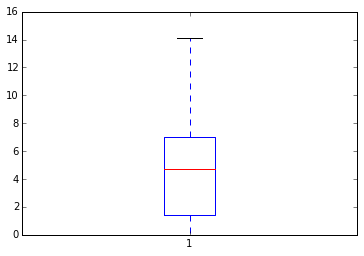

In [188]:
_ = plt.boxplot(M.data)

## save results

In [189]:
## inverse index
%time h2w = dict([(v,k) for k,v in wordhasher.data.items()])
%time h2c = dict([(v,k) for k,v in contexthasher.data.items()])

CPU times: user 6.26 ms, sys: 444 µs, total: 6.71 ms
Wall time: 5.97 ms
CPU times: user 891 ms, sys: 60.1 ms, total: 951 ms
Wall time: 951 ms


In [190]:


import h5py, cPickle

h5f = h5py.File("data/word_vectors.h5", "w")
%time h5f.create_dataset("data", data = wvectors)
h5f.close()

%time cPickle.dump(h2w, open("data/inverse_word_hash.pkl", "w"))
%time cPickle.dump(wordhasher.data, open("data/word_hash.pkl", "w"))
#%time cPickle.dump(h2c, open("data/inverse_context_hash.pkl", "w"))

CPU times: user 322 µs, sys: 4.27 ms, total: 4.59 ms
Wall time: 4.55 ms
CPU times: user 11.4 ms, sys: 950 µs, total: 12.3 ms
Wall time: 12.1 ms
CPU times: user 8.43 ms, sys: 593 µs, total: 9.03 ms
Wall time: 9.05 ms


## Evaluate Performance

In [191]:
import h5py, cPickle
h5f = h5py.File("data/word_vectors.h5", "r")
wvectors = h5f["data"][:]
h5f.close()

h2w = cPickle.load(open("data/inverse_word_hash.pkl"))
w2h = cPickle.load(open("data/word_hash.pkl"))

In [192]:
## use flann to find knn
import pyflann as pf
from scipy import stats

class NearestNeighbor(object):
    def __init__(self, k = 5, algorithm="kdtree", distance_type="euclidean"):
        pf.set_distance_type(distance_type)
        self.flann = pf.FLANN()
        self.k = k
        self.algorithm = "autotuned"#algorithm
        self.iterations = 100
    def train(self, X):
        self.X_ = X
    def nearest(self, X):
        min_index, dists = self.flann.nn(self.X_, X, self.k, 
                                         algorithm = self.algorithm, 
                                         iterations=self.iterations)
        return min_index, dists

### Nearest Neighbor

In [224]:
nn=NearestNeighbor()
nn.train(wvectors)
%time neighbors, dists =nn.nearest(wvectors)
for row in neighbors[1860:1870, :]:
    print [h2w[r] for r in row]

CPU times: user 1min 15s, sys: 2.09 s, total: 1min 17s
Wall time: 1min 17s
['divine', 'albanians', 'performers', 'twelve', 'experimental']
['periods', 'cooking', 'drinking', 'developer', 'compilers']
['trinity', 'self', 'liver', 'playoffs', 'monitor']
['london', 'paris', 'berlin', 'california', 'oregon']
['blue', 'tanakh', 'surviving', 'infection', 'nuclear']
['jews', 'soldiers', 'votes', 'arabs', 'cards']
['manufacture', 'aftermath', 'exercise', 'coordination', 'plans']
['soon', 'apparently', 'entirely', 'directly', 'essentially']
['outbreak', 'turn', 'dissolution', 'passing', 'passage']
['cold', 'korean', 'trojan', 'revolutionary', 'civil']


In [223]:
nn=NearestNeighbor()
nn.train(normalized_wvectors)
%time neighbors, dists =nn.nearest(wvectors)
for row in neighbors[1860:1870, :]:
    print [h2w[r] for r in row]

CPU times: user 1min 19s, sys: 2.75 s, total: 1min 22s
Wall time: 1min 21s
['divine', 'indians', 'daleks', 'poor', 'lowlands']
['editors', 'fruits', 'cooking', 'squares', 'lawyers']
['trinity', 'alps', 'buddha', 'cell', 'eu']
['london', 'berlin', 'paris', 'vienna', 'geneva']
['blue', 'atlantic', 'southwestern', 'northeastern', 'southeastern']
['jews', 'planets', 'dinosaurs', 'communists', 'canal']
['aftermath', 'eyes', 'course', 'face', 'solving']
['soon', 'even', 'barely', 'naturally', 'apparently']
['outbreak', 'arrival', 'turn', 'passage', 'dissolution']
['cold', 'anti', 'trojan', 'civil', 'korean']


In [200]:
wvectors.min(), wvectors.max(), normalized_wvectors.min(), normalized_wvectors.max()

(-164.06434580654258,
 149.53418664335788,
 -0.86203627523967263,
 0.93082859368188209)

In [201]:
dists.min(), dists.max()

(1.3434038308555481e-08, 36149.457381732056)

### Clustering

In [202]:
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=250, )
%time labels = kmeans.fit_predict(normalized_wvectors)

CPU times: user 1.49 s, sys: 3.88 ms, total: 1.49 s
Wall time: 1.49 s


In [203]:
Counter(labels)

Counter({44: 173, 4: 149, 17: 144, 26: 140, 31: 132, 230: 118, 225: 111, 6: 108, 170: 106, 235: 106, 137: 105, 20: 96, 249: 96, 178: 95, 217: 94, 106: 93, 48: 92, 152: 92, 205: 86, 62: 85, 71: 80, 164: 76, 197: 75, 25: 72, 30: 71, 40: 71, 183: 70, 0: 66, 103: 66, 96: 63, 112: 62, 29: 61, 165: 60, 63: 59, 5: 58, 65: 58, 181: 58, 247: 57, 49: 54, 80: 54, 189: 54, 202: 54, 168: 53, 210: 53, 213: 52, 124: 51, 77: 50, 203: 50, 199: 49, 81: 48, 238: 48, 33: 47, 52: 47, 162: 47, 198: 47, 22: 46, 47: 46, 129: 46, 132: 46, 149: 46, 54: 45, 24: 44, 41: 44, 3: 43, 13: 43, 173: 43, 226: 43, 67: 42, 192: 42, 240: 42, 241: 42, 58: 41, 115: 41, 127: 41, 169: 41, 56: 40, 113: 40, 148: 40, 184: 40, 27: 39, 68: 38, 83: 38, 139: 38, 179: 38, 218: 38, 231: 38, 15: 37, 109: 37, 172: 37, 7: 35, 74: 35, 23: 34, 37: 34, 91: 34, 216: 34, 246: 34, 36: 33, 185: 33, 215: 33, 78: 32, 110: 32, 144: 32, 204: 32, 45: 30, 46: 30, 72: 30, 87: 30, 145: 30, 150: 30, 32: 29, 180: 29, 209: 29, 243: 29, 39: 28, 114: 28, 193

In [207]:
ic = 155
for i in np.where(labels==ic)[0][:50]:
    print h2w[i]

science
philosophy
chemistry
biology
anatomy
mathematics
literature
physics
physiology
linguistics
ecology
genetics


In [225]:
ifrance, iparis, iuk, ilondon = w2h["king"], w2h["man"], w2h["queen"], w2h["woman"]

In [226]:
v = wvectors[ifrance] - wvectors[iparis] + wvectors[iuk]
u = wvectors[ilondon]

In [227]:
np.sqrt(np.sum((u-v)**2))

64.003799942148163

In [228]:
dists[ilondon, :]

array([   0.        ,   68.35350855,  163.82621343,  259.84915276,
        260.43805268])

In [232]:
for row in neighbors[ilondon:ilondon+1, :]:
    print [h2w[r] for r in row]

['woman', 'player', 'child', 'physician', 'soldier']
